In [1]:
import pinocchio as pin
import numpy as np
from pinocchio.visualize import MeshcatVisualizer
import hppfcl as fcl 
from tqdm import trange
import matplotlib.pyplot as plt
import time
import crocoddyl as cdl
import example_robot_data as erd
from tqdm import trange
from multiprocessing import Pool
import imageio
import os
from pathlib import Path
from tqdm import tqdm
import example_robot_data as erd

In [3]:
def make_video(viz, positions, name, fps):
    imgs = []
    for q_i in positions:
        viz.display(q_i)
        img_i = np.array(viz.viewer.get_image())
        imgs += [img_i]
    
    writer = imageio.get_writer(name, fps=fps)
    for im in tqdm(imgs):
        writer.append_data(im)
    writer.close()
    return 

path_curr = Path().cwd()
os.makedirs(path_curr/'videos', exist_ok=True)

## Adaptive smoothing for DDP

In [11]:
robot = erd.load("double_pendulum")
model = robot.model

In [12]:
end_placement = pin.SE3.Identity()
end_placement.translation = np.array([0.,0.,0.2])
end_frame = pin.Frame("end_pendulum_frame", model.getJointId("joint2"), 0, end_placement, pin.FrameType(3))
model.addFrame(end_frame)
data = model.createData()

In [13]:
geom_model = robot.collision_model
geom_data = robot.collision_data

In [14]:
q_init = np.zeros(model.nq) #+ 1.*np.pi
q_init[0] +=  1.*np.pi
q_init[1] +=  0.*np.pi
v_init = np.zeros(model.nv)
x0 = np.concatenate([q_init, v_init])
a_init = np.zeros(model.nv)
pin.forwardKinematics(model, data, q_init)
pin.updateFramePlacements(model, data)
pin.updateGeometryPlacements(model, data, geom_model, geom_data)

In [9]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [15]:
def aba_with_friction(model,data,q,v,u,cf):
    a = pin.aba(model,data,q,v,u)
    Minv = np.linalg.inv(pin.crba(model,data,q))
    #Minv = data.Minv
    af = np.where(np.abs(v) < 1e-3, 
                  np.sign(a)*np.clip(np.abs(a)-np.abs(np.dot(Minv,np.sign(a)*cf)),0,None),
                  a-np.dot(Minv,np.sign(v)*cf))
    return af

def RK4Update_with_friction(model,data,q,v,u,dt,cf):
    a1 = aba_with_friction(model,data,q,v,u,cf)
    q1,v1 = pin.integrate(model, q,v*dt/2), v+a1*dt/2
    a2 = aba_with_friction(model,data,q1,v1,u,cf)
    q2,v2 = pin.integrate(model, q,v1*dt/2), v+a2*dt/2
    a3 = aba_with_friction(model,data,q2,v2,u,cf)
    q3,v3 = pin.integrate(model, q,v2*dt), v+a3*dt
    a4 = aba_with_friction(model,data,q3,v3,u,cf)
    return pin.integrate(model, q,(dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

In [16]:
class DifferentialSmoothFrictionDynamics(cdl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel, nbSamples, noiseIntensity, cf):
        cdl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)
        self.nbSamples = nbSamples
        self.noiseIntensity = noiseIntensity
        self.costWeights = 0
        self.cf = cf

    def calc(self, data, x, u=None, uNoise = None):
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        data.xout[:] = 0
        for ui in uNoise:
            data.xout[:] += aba_with_friction(self.state.pinocchio, data.pinocchio, q, v, u+ ui, self.cf)/self.nbSamples
        # Computing the cost value and residuals
        pin.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pin.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost
        


    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        uNoise = self.noiseIntensity*np.random.normal(size=self.nbSamples)
        self.calc(data, x, u, uNoise)
        # Computing the dynamics derivatives
        data.Fx[:] = 0
        data.Fu[:] = 0
        for ui in uNoise:
            pin.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u+ui)
            Fxi = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            Fui = data.pinocchio.Minv
            for i in range(self.state.nv):
                if np.abs(v)[i]<1e-3:
                    if data.xout[i] != 0:
                        continue
                    else:
                        Fxi[i][:] = 0
                        Fui[i][:] = 0
                else:
                    continue
            data.Fx[:] += Fxi/self.nbSamples
            data.Fu[:] += Fui/self.nbSamples
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)
        

    def createData(self):
        data = cdl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = self.state.pinocchio.createData()#pin.Data(self.state.pinocchio)
        data.multibody = cdl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model#

        return data

In [17]:
def adaptiveSolve(state, runningCostModel, terminalCostModel, T, DT, init_us, init_xs, init_noise = 3e-1, init_nbSamples = 4, maxIter = 100, alpha = .9):
    us = init_us
    xs = init_xs
    nbSamples = init_nbSamples
    noiseIntensity = init_noise
    cost = []
    for i in range(maxIter):
        pendulumDAM = DifferentialSmoothFrictionDynamics(state, runningCostModel,nbSamples, noiseIntensity, 0.01)
        #pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
        pendulumDAM.createData()
        terminalPendulumDAM = DifferentialSmoothFrictionDynamics(state, terminalCostModel,nbSamples, noiseIntensity, 0.01)
        #terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
        terminalPendulumDAM.createData()
        runningModel = cdl.IntegratedActionModelEuler(
            pendulumDAM, DT)
        terminalModel = cdl.IntegratedActionModelEuler(
            terminalPendulumDAM, 0.)
        problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)
        ddp = cdl.SolverFDDP(problem)
        log = cdl.CallbackLogger()

        ddp.setCallbacks([log,
                          cdl.CallbackVerbose()])
        # Solving it with the DDP algorithm
        finished = ddp.solve(xs, us, 1)
        print(len(xs))
        xs = ddp.xs
        us = ddp.us.tolist()
        cost += log.costs
        noiseIntensity *= alpha
        nbSamples = max(1,int(init_nbSamples*(.99**i)))
        if finished:
            break
    return finished, ddp, cost

In [21]:
# Create the cost functions
#target = np.array([0.0290872, 0., 0.135])
#Mref = cdl.FrameTranslation(model.getFrameId("link2"), target)
target = np.array([0.0290872, 0., 0.435])
Mref = cdl.FrameTranslation(model.getFrameId("end_pendulum_frame"), target)
state = cdl.StateMultibody(model)
goalTrackingCost = cdl.CostModelFrameTranslation(state, Mref)
xRegCost = cdl.CostModelState(state)
uRegCost = cdl.CostModelControl(state)

# Create cost model per each action model
runningCostModel = cdl.CostModelSum(state)
terminalCostModel = cdl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("pendulumPose", goalTrackingCost, 1e-7)
runningCostModel.addCost("éstateReg", xRegCost, 1e-7)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-1)
terminalCostModel.addCost("pendulumPose", goalTrackingCost, 1.)
terminalCostModel.addCost("stateReg", xRegCost, 1e-7)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-7)

# Running and terminal action models
DT = 1e-3
noiseIntensity = 3e-1
nbSamples = 4

pendulumDAM = DifferentialSmoothFrictionDynamics(state, runningCostModel,nbSamples, noiseIntensity, 0.01)
#pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialSmoothFrictionDynamics(state, terminalCostModel,nbSamples, noiseIntensity, 0.01)
#terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 0.)
problem = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [22]:
T = 1500

In [25]:
# Solving it with the DDP algorithm
init_us = [np.zeros_like(a_init)]*T
init_xs = problem.rollout(init_us)
print("init",len(init_xs))
finished, ddp, cost = adaptiveSolve(state, runningCostModel, terminalCostModel, T, DT, init_us, init_xs, noiseIntensity*3, nbSamples, 500, .5)
print(finished)

init 1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.53466e-01  3.52176e-06  3.49264e-02  1.00000e-09  1.00000e-09   0.2500     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  9.53924e-02  2.97419e-05  2.93034e-01  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  3.99476e-02  1.87443e-05  1.83492e-01  1.00000e-09  1.00000e-09   0.5000     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.44580e-02  7.54810e-06  7.35942e-02  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.08683e-02  2.43448e-06  2.39064e-02  1.00000e-09  1.00000e-09   0.2500     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  9.54498e-03  1.55830e-06  1.52527e-02  1.00000e-09  1.00000e-09   0.2500

   0  6.43132e-1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
150103  4.21089e-08  4.14734e-04  1.00000e-09  1.00000e-09   0.1250     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.40979e-03  3.27300e-07  3.22722e-03  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.39807e-03  5.12618e-08  5.05233e-04  1.00000e-09  1.00000e-09   0.0625     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.38470e-03  1.81664e-07  1.79108e-03  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.37108e-03  4.11970e-08  4.06043e-04  1.00000e-09  1.00000e-09   0.0625     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.36143e-03  1.18609e-07  1.16925e-03  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	   

iter 	 cost 	1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.05203e-03  1.97212e-08  1.94553e-04  1.00000e-09  1.00000e-09   0.0625     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.04631e-03  1.36361e-07  1.34442e-03  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.04357e-03  4.41780e-08  4.35549e-04  1.00000e-09  1.00000e-09   0.0312     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.03940e-03  7.41907e-08  7.31406e-04  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.03675e-03  2.90886e-08  2.86884e-04  1.00000e-09  1.00000e-09   0.0312     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  6.03338e-03  5.05486e-08  4.9830

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.87358e-03  1.06446e-1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
150108  1.04883e-04  1.00000e-09  1.00000e-09   0.0312     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.87185e-03  2.50567e-08  2.47259e-04  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.87071e-03  1.03285e-08  1.01769e-04  1.00000e-09  1.00000e-09   0.0312     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.86910e-03  2.36670e-08  2.33552e-04  1.00000e-09  1.00000e-09   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.86826e-03  1.12583e-08  1.10915e-04  1.00000e-09  1.00000e-09   0.0312     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.86631e-03  2.96929e-08  2

iter 	 cost 	      stop 	 1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501   grad 	  xreg 	      ureg 	 step 	 feas
   0  5.77467e-03  4.17066e-08  4.10088e-04  1.00000e-08  1.00000e-08   0.0078     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.76736e-03  4.99949e-09  4.91848e-05  1.00000e-09  1.00000e-09   0.2500     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.76454e-03  6.92758e-08  6.81671e-04  1.00000e-08  1.00000e-08   0.0078     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.75484e-03  3.89099e-09  3.83276e-05  1.00000e-09  1.00000e-09   0.5000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.74716e-03  2.04124e-07  2.01029e-03  1.00000e-08  1.00000e-08   0.0078     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.74648e-03  4.00060e-09  3.9533

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
150105  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8

iter 	 cost 	      stop 	    grad 	  xr1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501eg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-08  1.00000e-08   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.71443e-03  8.47056e-09  8.36822e-05  1.00000e-1501
1501
1501
1501
1501
1501
1501
1501
1501


KeyboardInterrupt: 

In [133]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [134]:
xs = np.stack(ddp.xs)
viz.play(xs[:,:model.nq].T,DT)

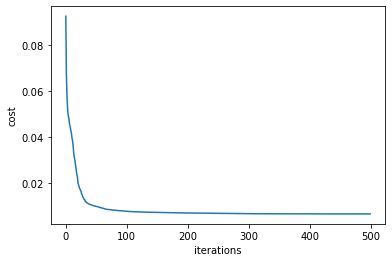

In [135]:
plt.figure()
plt.plot([i for i in range(len(cost))],cost)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.show()

In [129]:
pendulumDAM = DifferentialSmoothFrictionDynamics(state, runningCostModel, 1, 0, 0.01)
#pendulumDAM = cdl.DifferentialActionModelNumDiff(pendulumDAM,False)
pendulumDAM.createData()
terminalPendulumDAM = DifferentialSmoothFrictionDynamics(state, terminalCostModel, 1, 0, 0.01)
#terminalPendulumDAM = cdl.DifferentialActionModelNumDiff(terminalPendulumDAM,False)
terminalPendulumDAM.createData()
runningModel = cdl.IntegratedActionModelEuler(
    pendulumDAM, DT)
terminalModel = cdl.IntegratedActionModelEuler(
    terminalPendulumDAM, 0.)

problem_test = cdl.ShootingProblem(x0, [runningModel] * T, terminalModel)
ddp_test = cdl.SolverFDDP(problem)
log_test = cdl.CallbackLogger()

ddp_test.setCallbacks([log,
                  cdl.CallbackVerbose()])
# Solving it with the DDP algorithm
finished = ddp_test.solve(ddp.xs, ddp.us.tolist(), 10)